In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import blend_modes
from tqdm.notebook import tqdm

sns.set(font_scale=1.3)

### Вспомогательные функции

In [2]:
def show_opencv_image(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.axis('off')
    
    
def scale_image(image, scale, box=None):
    h, w = image.shape[:2]
    new_h, new_w = int(h / scale), int(w / scale)
    image = cv2.resize(image, (new_w, new_h))
    
    if box is not None:
        box = box / scale
        
    return image, box


def apply_homography(image, matrix, full_image=False):
    h, w = image.shape[:2]
    input_box = np.array([[0, 0], [w, 0], [w, h], [0, h]]).astype(np.float32)
    
    h, w = image1.shape[:2]
    if full_image:
        output_box = cv2.perspectiveTransform(input_box[None], matrix)[0]
        x, y, w, h = cv2.boundingRect(output_box)
        output_box -= np.array([x, y])
        matrix = cv2.getPerspectiveTransform(input_box, output_box)

    warped_box = cv2.perspectiveTransform(input_box[None, :, :], matrix)[0]
    warped_image = cv2.warpPerspective(image, matrix, (w, h), flags=cv2.INTER_CUBIC)
    
    return warped_image, warped_box


def random_shift(warped_image, warped_box, output_shape):
    image_h, image_w = warped_image.shape[:2]
    output_h, output_w = output_shape[:2]

    if image_h == output_h:
        x = 0
    else:
        x = np.random.randint(0, output_h - image_h)
    if image_w == output_w:
        y = 0
    else:
        y = np.random.randint(0, output_w - image_w)

    warped_box[:, 1] += x
    warped_box[:, 0] += y
    warped_box = warped_box.astype(int).astype(np.float32)

    dst_image = np.zeros(output_shape, dtype=np.uint8)
    dst_image[x:x+image_h, y:y+image_w] = warped_image
    # empty_image[empty_image == 0] = 128

    return dst_image, warped_box


def random_homography(image, matrix, output_shape, scale=1):
    warped_image, warped_box = apply_homography(image, matrix, full_image=True)

    h0, w0 = warped_image.shape[:2]
    h1, w1 = output_shape[:2]
    scale = max(h0 / h1, w0 / w1, 1) * scale
    
    warped_image, warped_box = scale_image(warped_image, scale, warped_box)
    warped_image, warped_box = random_shift(warped_image, warped_box, output_shape)
    
    return warped_image, warped_box


def add_alpha_channel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    image[:, :, 3] = 255
    return image


def overlay(image, warped_image, warped_box, alpha=1, kernel_size=257):
    image_copy = cv2.GaussianBlur(image.copy(), (kernel_size, kernel_size), 0)

    image_copy = add_alpha_channel(image_copy).astype(np.float32)
    warped_image = add_alpha_channel(warped_image).astype(np.float32)

    warped_image = cv2.GaussianBlur(warped_image, (13, 13), 0)
    image_copy = blend_modes.overlay(image_copy, warped_image, alpha)

    mask = np.zeros(warped_image.shape[:2], np.uint8)
    mask = cv2.fillPoly(mask, [warped_box.astype(int)], 255)
    mask = cv2.polylines(mask, [np.int32(warped_box)], True, 0, 5)

    image[mask == 255] = image_copy[:, :, :3][mask == 255]
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR).astype(np.uint8)

    return image

### Подготавливаем midv500 и матрицы гомографий

In [3]:
data = np.load('./midv500/data.npy', allow_pickle=True)
data = pd.DataFrame(data, columns=['image0', 'image1', 'true_box0', 'true_box1'])

In [4]:
pathes = data.iloc[np.arange(0, 15000, 300), 0].values
shapes = np.array([cv2.imread(path).shape[:2] for path in pathes])

In [5]:
homographies = []
for true_box0, true_box1 in zip(data['true_box0'], data['true_box1']):
    matrix, _ = cv2.findHomography(true_box0, true_box1)
    homographies.append(matrix.reshape(-1))
    
homographies = np.array(homographies)

In [6]:
desired_idx = [
    31, 300 * 4, 300 * 7, 300 * 8, 300 * 11, 300 * 13, 300 * 20, 300 * 31, 300 * 32, 300 * 44, 
    300 * 45, 300 * 20 + 30, 300 * 4 + 30 * 8, 300 * 47 + 30 * 8, 300 * 26 + 30 * 5, 300 * 45 + 30 * 5, 
    30 * 4, 300 * 29 + 30 * 4, 300 * 38 + 30 * 4, 300 * 47 + 30 * 4
]

desired_idx = np.array(desired_idx)
assert len(desired_idx) == 20

### Пример данных

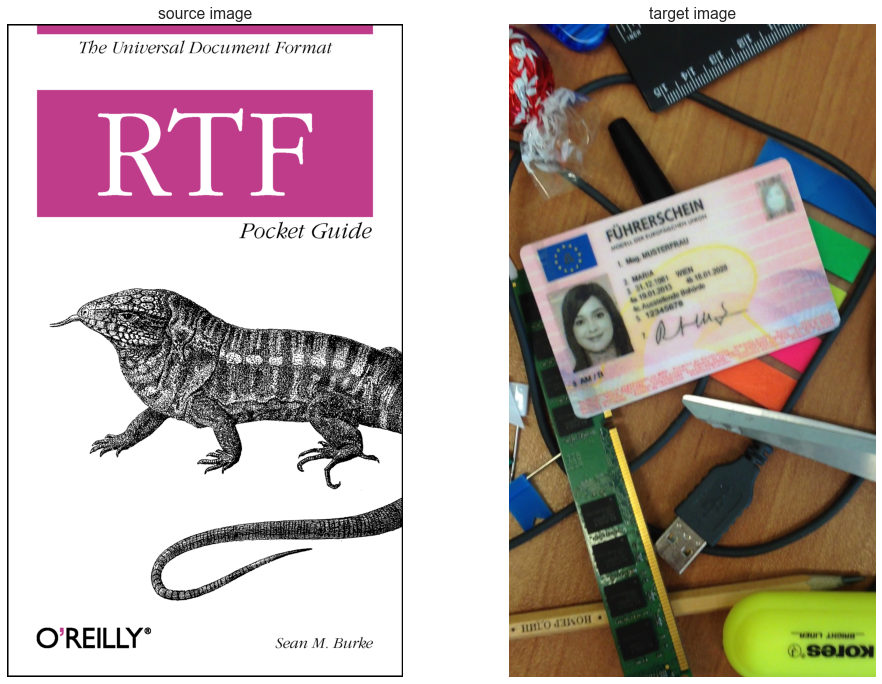

In [7]:
path_to_images = './images'
document_pathes = [os.path.join(path_to_images, path) for path in os.listdir(path_to_images)]

image0 = cv2.imread(document_pathes[0])
image1 = cv2.imread(data['image1'][314])

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.title('source image')
show_opencv_image(image0)

plt.subplot(1, 2, 2)
plt.title('target image')
show_opencv_image(image1)

### Пример применения гомографий

#### Произвольная гомография

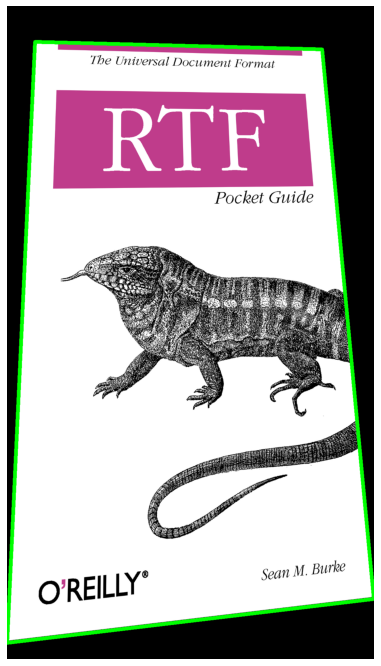

In [16]:
matrix = homographies[np.random.choice(len(data))].reshape(3, 3)
warped_image0, warped_box0 = random_homography(image0, matrix, image1.shape)

plt.figure(figsize=(16, 12))
show_opencv_image(cv2.polylines(warped_image0.copy(), [np.int32(warped_box0)], True, (0, 255, 0), 10))

#### Одна из выбранных вручную

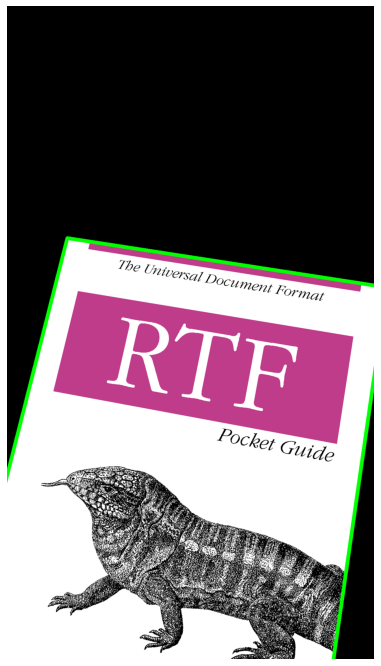

In [20]:
matrix = homographies[np.random.choice(desired_idx)].reshape(3, 3)
warped_image0, warped_box0 = apply_homography(image0, matrix)

plt.figure(figsize=(16, 12))
show_opencv_image(cv2.polylines(warped_image0.copy(), [np.int32(warped_box0)], True, (0, 255, 0), 10))

#### Пример overlay

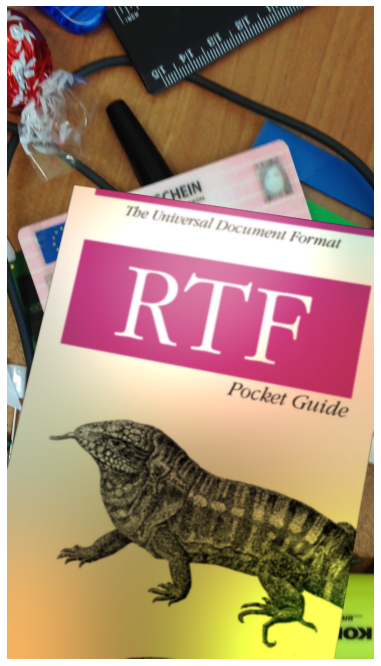

In [13]:
overlayed_image = overlay(image1.copy(), warped_image0.copy(), warped_box0.copy(), kernel_size=1201)

plt.figure(figsize=(16, 12))
show_opencv_image(overlayed_image)

### Применяем гомографии к данным. Сначала применим случайные преобразования, посмотрим на результат и, при необходимости, заменим плохие изображения.

#### Сначала рандомные

In [62]:
save_folder = './augmented_images'

i = 9

directory = os.path.join(save_folder, 'image_{}'.format(i + 1))
if not os.path.exists(directory):
    os.makedirs(directory)
    
image0 = cv2.imread(document_pathes[i])

for t in tqdm(range(10)):
    j = np.random.choice(len(data))

    image1 = cv2.imread(data['image1'][j])
    matrix = homographies[j].reshape(3, 3)

    warped_image0, warped_box0 = random_homography(image0, matrix, image1.shape)
    overlayed_image = overlay(image1.copy(), warped_image0.copy(), warped_box0.copy(), kernel_size=1001)

    cv2.imwrite(os.path.join(directory, 'augmented_image_{}.png'.format(t + 1)), overlayed_image)

  0%|          | 0/10 [00:00<?, ?it/s]

####  Теперь улучшим результат, применив наиболее хорошие гомографии, выбранные вручную

In [63]:
for t in tqdm([3, 5, 6]):
    j = np.random.choice(desired_idx)

    image1 = cv2.imread(data['image1'][j])
    matrix = homographies[j].reshape(3, 3)

    warped_image0, warped_box0 = apply_homography(image0, matrix)
    overlayed_image = overlay(image1.copy(), warped_image0.copy(), warped_box0.copy(), kernel_size=1001)

    cv2.imwrite(os.path.join(directory, 'augmented_image_{}.png'.format(t)), overlayed_image)

  0%|          | 0/3 [00:00<?, ?it/s]